# Preprocessing of squat or pushup raw coordinate text files into segmented and normalized reps

In [7]:
#=====[ Import dependencies ]====
import numpy as np
import matplotlib.pyplot as plt
import sys
# sys.path.append('/usr/local/lib/python2.7/site-packages')
import pandas as pd
import pickle

# sys.path.append('/Users/admin3/Dropbox/Stanford/Fall-2015/CS221/project/ai_trainer/data')
sys.path.append('../data')
sys.path.append('../data/squat_pushupData_10to20')
sys.path.append('../inference')

#=====[ Import Data ]=====
# import coords1 as cd
import coordKeys as keys
import coordKeysZ as keysZ

#=====[ Import Labels ]======
import labels

%matplotlib inline

# Step 1: Import Data

In [8]:
#=====[ Get labels ]=====
y = labels.labels15
# print 'Number of labeled squats: %d' % len(y)

#=====[ Get raw text files that specify x, y, z coordinates for each joint for each frame ]=====
file_to_open =  '../data/raw_data/squat_pushupData_10to20/squatData11.txt'
# file_to_save = '../data/squat_coords/squat17.p'

In [9]:
#=====[ Import data from text file ] =====

#=====[ There are parameters we can use to cut off unclean coordinates from either end of our dataframe. We 
#=====[ manually do this here, but in our full pipeline, we automate this ]=====

front_cut = 0
back_cut = 0

data = []
with open(file_to_open) as f:
    for line in f:
        try:
            data.append([float(x.replace('\r\n','')) for x in line.split(',')])
        except Exception as e:
            print e

#=====[ Put data in data frame, apply front and back cut, and reset index ]=====
df = pd.DataFrame(data, columns=keysZ.columns)
df = df[front_cut:df.shape[0]-back_cut]
df = df.set_index([range(0,df.shape[0])])
df.head()

,SpineBaseX,SpineBaseY,SpineBaseZ,SpineMidX,SpineMidY,SpineMidZ,NeckX,NeckY,NeckZ,HeadX,...,HandTipLeftZ,ThumbLeftX,ThumbLeftY,ThumbLeftZ,HandTipRightX,HandTipRightY,HandTipRightZ,ThumbRightX,ThumbRightY,ThumbRightZ
0,268.087921,214.151398,2.461200,270.304779,168.918930,2.381243,272.656830,121.252571,2.288960,269.095581,...,2.265666,258.598938,97.327873,2.197485,281.236877,104.400841,2.262897,281.058990,96.115074,2.203706
1,268.032715,213.888229,2.460179,270.303864,168.673157,2.380860,272.704803,121.009949,2.289105,269.010925,...,2.252505,258.441345,97.079971,2.198733,277.166809,113.501595,2.255517,280.968567,95.880341,2.207965
2,267.947815,213.013809,2.458654,270.360382,167.195999,2.379898,272.981354,118.766914,2.289176,268.762665,...,2.264329,259.032074,97.067520,2.196846,277.506104,110.495468,2.247087,280.543182,94.765907,2.209462
3,267.633301,209.600357,2.455843,269.862274,163.486923,2.379188,272.246582,115.034958,2.290447,268.826935,...,2.263563,258.936493,93.406822,2.202765,277.000000,108.177681,2.246054,280.473572,90.704796,2.206471
4,267.555908,204.713547,2.451607,268.878632,160.626099,2.376218,270.512543,113.358543,2.288266,268.808228,...,2.273626,257.411774,87.954453,2.204583,277.201294,104.200134,2.261008,280.800934,87.065964,2.205867


# Step 2: Isolate Individual Squats

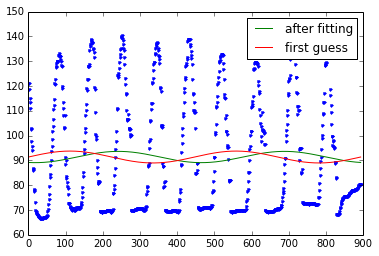

In [24]:

#====[ Coordinates used to similuate kinect stream ]=====
streaming_coords = np.array(df['NeckY'])

#=====[ Real-time segmentation ]=====

import numpy as np
from scipy.optimize import leastsq
import pylab as plt

N = len(streaming_coords)
t = np.linspace(0, 4*np.pi, N)
data = 3.0*np.sin(t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_mean = np.mean(data)
guess_std = 3*np.std(data)/(2**0.5)
guess_phase = 0

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(t+x[1]) + x[2] - data
est_std, est_phase, est_mean = leastsq(optimize_func, [guess_std, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_std*np.sin(t+est_phase) + est_mean

plt.plot(data, '.')
plt.plot(data_fit, label='after fitting')
plt.plot(data_first_guess, label='first guess')
plt.legend()
plt.show()

In [49]:
#=====[ Real-time segmentation ]=====

#====[ Coordinates used to similuate kinect stream ]=====
streaming_coords = np.array(df['NeckY'])
min_y = np.median(sorted(streaming_coords)[0:10])
print min_y
transform = np.fft.fft(streaming_coords)

# y_coords = []

y_coords = np.array(df['NeckY'])
#=====[ Hyper parameter used to smooth gradients over the next alpha gradients ]=====
alpha = 20
grads = []
# for idx, coord in enumerate(streaming_coords):
#     y_coords.append[coord]
    
#     if idx > 0:
#         grads.append[y_coords[idx] - y_coords[idx-1]]
        
#     for idx2, y in enumerate(y_coords):
#         if idx2 + alpha < idx:
            

grads = []
for idx, y in enumerate(y_coords):
    if idx > 0:
        grads.append(y - y_coords[idx-1])

forward_grads = []
beta = 10
for idx, y in enumerate(y_coords):
    forward_grads.append(np.mean(grads[max(0,idx-beta):min(idx+beta,idx-1)]))

plt.plot(np.abs(forward_grads))
plt.plot(y_coords-80)
# for idx,x in enumerate(forward_grads):
#     print x

66.837059021


TypeError: 'numpy.float64' object is not callable

15
0.0156451416016
-0.00884521484377
-0.00488891601563
-0.206155395508
-0.00878326416016
-0.0136499023437
-0.166386413574
-0.280387573242
-0.317847900391
-0.177679748535
-0.606900939941
-0.0840859985352
-0.141885375977
-0.597601623535
0.0351538085938
-0.326801757813
-0.0980731201172
-0.241597900391
-0.203031921387
-0.106782226562
[44, 130, 186, 213, 315, 402, 456, 490, 556, 582, 643, 677, 733, 777, 855]


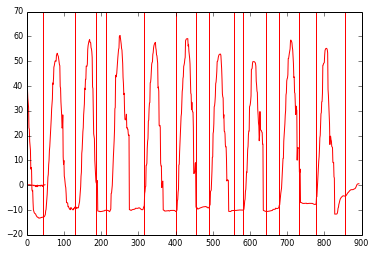

In [25]:
#=====[ Real-time segmentation ]=====

#====[ Coordinates used to similuate kinect stream ]=====
streaming_coords = np.array(df['NeckY'])

transform = np.fft.fft(streaming_coords)

# y_coords = []

y_coords = np.array(df['NeckY'])
#=====[ Hyper parameter used to smooth gradients over the next alpha gradients ]=====
alpha = 25
grads = []
# for idx, coord in enumerate(streaming_coords):
#     y_coords.append[coord]
    
#     if idx > 0:
#         grads.append[y_coords[idx] - y_coords[idx-1]]
        
#     for idx2, y in enumerate(y_coords):
#         if idx2 + alpha < idx:
            

grads = []
for idx, y in enumerate(y_coords):
    if idx > 0:
        grads.append(y - y_coords[idx-1])

forward_grads = []
for idx, y in enumerate(y_coords):
    if idx < len(y_coords) - alpha:
        forward_grads.append(np.mean(grads[idx:idx+alpha]))
# plt.plot(grads[0:120])

grads2 = []
for idx, point in enumerate(forward_grads):
    if idx > 0:
        grads2.append(point - forward_grads[idx-1])

points = []
# for idx, point in enumerate(forward_grads):
#     if idx < len(forward_grads) - 1:
#         if (forward_grads[idx] > 0 and forward_grads[idx+1] < 0) or (forward_grads[idx] < 0 and forward_grads[idx+1] > 0):
#             points.append(idx)

counter = 0
new = True
for idx, point in enumerate(grads2):
    if new:
        if idx < len(grads2) - 3:
            if (grads2[idx] > 0 and grads2[idx+1] > 0 and grads2[idx+2] < 0 and grads2[idx+3] < 0):
                points.append(idx +1)
                new = False
                counter = 0
            elif (grads2[idx] > 0 and grads2[idx+1] > 0 and grads2[idx+2] < 0):
                points.append(idx+1)
                new = False
                counter = 0
            elif (grads2[idx] > 0 and grads2[idx+1] < 0 and grads2[idx+2] < 0):
                points.append(idx+1)
                new = False
                counter = 0
    counter += 1
    if counter > alpha:
        new = True
        counter = 0

beta = 30
mean = np.mean(y_coords[points])
points = [x for x in points if y_coords[x] < mean]

print len(points)
prev_point = len(points)-1

# idx = 0
# while(True):      
# #     if points[idx] > 450:
# #         print "test"
# #         print points[prev_point]
# #         print points[idx]
#     if idx < len(points) -1 and np.abs(points[prev_point] - points[idx]) < beta:
#         if y_coords[prev_point] < y_coords[idx]:
#             points.remove(points[idx])
#         else:
#             points.remove(points[prev_point])
#             prev_point =idx - 1
#         continue
#     prev_point = idx
#     idx += 1
#     if idx > len(points) - 2:
#         break

for point in points:
#     if idx % 2 == 1:
    plt.axvline(point,color='r')

plt.tick_params(axis='x', labelsize=8)
plt.tick_params(axis='y', labelsize=8)
# plt.plot(forward_grads, color='b')
plt.plot(grads2[475:525],color='r')
plt.plot(y_coords - 80, color='r')

for x in grads2[490:510]:
    print x
print points

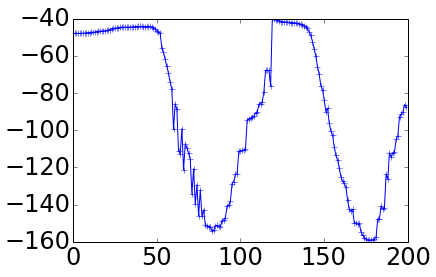

In [35]:
#=====[ Extract y_coords for Neck -- provides a stable point of reference ]=====
y_coords = np.array(df.get('NeckY'))
plt.plot(-y_coords[0:200],marker='+')

# Get Max Indices

In [32]:
#=====[ Returns true if the specified index of y_coords is a minimum value ]=====
def is_min(y_coords, height, gradient, index, epsilon, beta):
    if np.abs(y_coords[index] - height)/height < epsilon:
        for i in range(1,beta):
            if gradient[index - i] > 0 or gradient[index + i - 1] < 0:
                return False
        return True
        
#=====[ Returns true if we suspect that we are in a new repetition ]=====
def in_new_squat(y_coords, height, index, delta):
    return abs((y_coords[index] - height)/height) > delta

#=====[ Gets local maxes within accepted epsilon of global max and with max len(y_coors)/gamma maxes ]=====
#=====[ For squats: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.5, beta ~ 1 ]=====
#=====[ For pushups: usual epsilon ~ 0.2, gamma ~ 20, delta ~ 0.2, beta ~ 1 ]=====

def get_local_mins(y_coords, epsilon=0.25, gamma=50, delta=0.5, beta=2):
    
    local_mins = []
    height = np.min(y_coords[len(y_coords)/3:len(y_coords)*2/3])
    gradient = np.gradient(y_coords)
    
    #=====[ Checks gradients to make sure we are looking at a local min ]=====
    min_located = False
    for index, dy in enumerate(gradient[2:]):
        if(min_located):
            if in_new_squat(y_coords, height, index, delta):
                min_located = False       
            else:
                continue
                
        if  is_min(y_coords, height, gradient, index, epsilon, beta + 1):
            local_mins.append(index)
            min_located = True
        
    return sorted(local_mins)

[30, 120, 205, 298, 401, 470, 553, 638, 722, 800, 875]


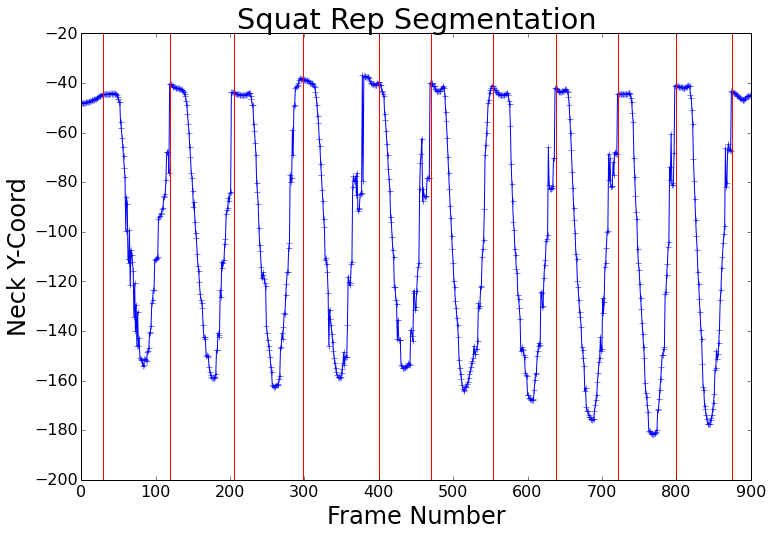

In [33]:
#=====[ Get maxes and plot with y_coords ]=====
mins = get_local_mins(y_coords)
plt.plot(-y_coords,marker='+')
print mins

for divide in mins:
    plt.axvline(divide,color='r')

#=====[ Add plot decorations ]=====    
plt.ylabel('Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.rcParams.update({'font.size': 24})
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Squat Rep Segmentation')
plt.savefig('squat_separation.png',dpi=200)

# Separate Exercise based on max points found

In [24]:
reps = []

#=====[ Get points from DF between each max found -- constitutes a single squat ]=====
for index,x in enumerate(mins):
    if(index == len(mins) -1 ):
        continue
    rep = (df.loc[x:mins[index+1]-1]).copy(True)
    reps.append(rep.set_index([range(rep.shape[0])]))

print "%d reps extracted, %d labels exracted" % (len(reps), len(y))

10 reps extracted, 10 labels exracted


# Step 3: Normalize Coordinates

In [25]:
# =====[ Helper Functions for getting normalizing parameters ]=====
def y_upper_bound(df):
    return np.min(df['HeadY'])

def y_lower_bound(df):
    return np.median(pd.concat([df['FootRightY'],df['FootLeftY']],axis =0))

def x_zero(df):
    return np.median(df['SpineMidX'])

def z_zero(df):
    return np.median(np.concatenate([df.get('FootLeftZ'),df.get('FootRightZ')],axis=0))

def scaling_factor(df):
    return np.abs(y_upper_bound(df) - y_lower_bound(df))

In [26]:
def normalize(df, reps, z_coords=False):
    
    #=====[ Normalizing constants for the entire set of exercises ]=====
    y_head = y_upper_bound(df)
    scale = scaling_factor(df)
    x_midpoint = x_zero(df)
    z_midpoint = z_zero(df)
    
    for rep in reps:
        
        #=====[ Even columns are x-coordinates, odd columns are y-coordinates -- normalize respectively ]=====
        for index, col in enumerate(rep.columns):
            if index % 3 == 2:
                rep[col] = rep[col].apply((lambda z: ((z - z_midpoint)/scale)))
            elif index % 3 == 1:
                rep[col] = rep[col].apply((lambda y: ((y - y_head)/scale)))
            else:
                rep[col] = rep[col].apply(lambda x: ((x - x_midpoint)/scale))                    

In [27]:
#=====[ Normalize squats: ensure z_coords is set to true if extracting 3-d coordinates ]=====
# from pu_normalization import normalize #<--- This line is used if preprocessing pushups

normalize(df, reps)

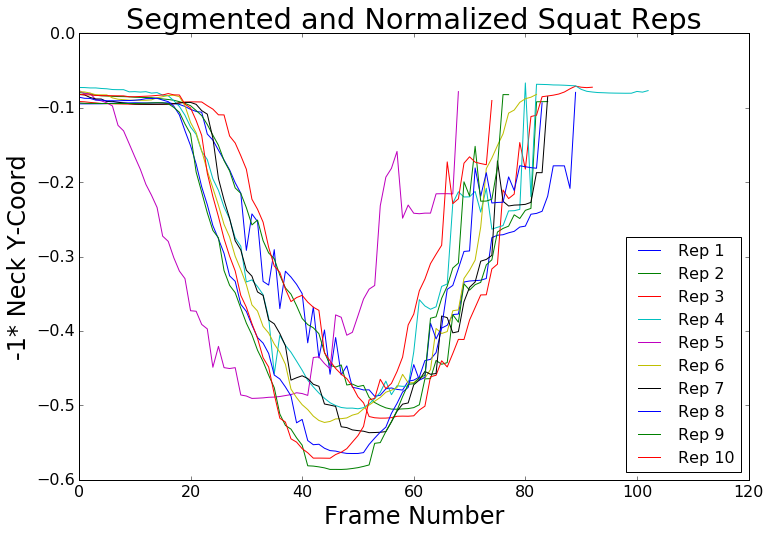

In [28]:
#=====[ Visual comparison between reps ]=====
for index, rep in enumerate(reps):
    plt.plot(-rep.get('NeckY'),label="Rep " + str(index + 1))
plt.legend(loc='lower right', prop={'size':16})
plt.ylabel('-1* Neck Y-Coord')
plt.xlabel('Frame Number')
figure = plt.gcf() # get current figure
figure.set_size_inches(12, 8)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.title('Segmented and Normalized Squat Reps')

# Compress reps and labels into a pickle file

In [ ]:
training_data = []

#=====[ Append label to our squats and pickle the (x,y) pairs ]=====
for index, rep in enumerate(reps):
    training_data.append((rep,y[index]))

In [ ]:
#=====[ Save squats in pickle file if desired ]=====
pickle.dump(training_data,open(file_to_save,'wb'))

# Visualize Scaled Body

In [29]:
def plotBody(df,frame):
    coords = np.array(df.loc[frame])
    xs = [coords[i] for i in range(0,coords.size) if i % 3 == 0]
    ys = [-1*coords[i] for i in range(0,coords.size) if i % 3 == 1]    
    zs = [coords[i] for i in range(0,coords.size) if i % 3 == 2]
    plt.plot(xs,ys,linestyle='None',marker='o',markersize=10)
    figure = plt.gcf()
    plt.axis([-.3, .3, -1.1, 0.1])
    figure.set_size_inches(5,8)


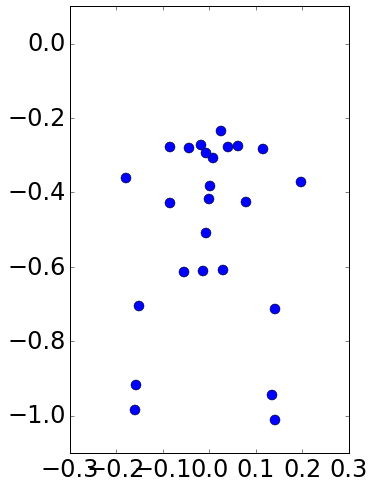

In [31]:
plotBody(reps[1],40)